In [73]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from scipy import stats
from pymer4.models import Lmer, Lm
import statsmodels  as sm

from pymer4.io import save_model, load_model

# Loading and preparing data

In [12]:
# Loading dataframe
df = pd.read_csv("data/exp1_implicit.csv")
df = df[df["invalid_catch"]==0] # Eliminates entire auditory block in which participant did not detect any visual catch (as it could mean they weren't even looking at the screen)

In [74]:
# Defining factors for pymer4 lmm function
pred = {"pred" : ["EXP", "VP"]}
ign_pred = {"ign_pred" : ["EXP", "VP"]}
relevant_expected = {"relevant_expected" : ["0", "1"]}
irrelevant_expected = {"irrelevant_expected" : ["0", "1"]}
att_learned = {"att_learned" : ["0", "1"]}
ign_learned = {"ign_learned" : ["0", "1"]}
modality = {"modality": ["auditory", "visual"]}
block = {"block_mod": ["1", "2", "3", "4", "5"]}

In [75]:
# Transforming numeric factors to string for pymer
df["relevant_expected"] = df["relevant_expected"].astype("str")
df["irrelevant_expected"] = df["irrelevant_expected"].astype("str")

df["att_learned"] = df["att_learned"].astype("str")
df["ign_learned"] = df["ign_learned"].astype("str")

df["block_mod"] = df["block_mod"].astype("str")

# Functions

Here I define functions to use for several analyses

In [76]:
def reportAIC(models):
    modeln = 0
    for model in models:
        print(f"Model {modeln}: {model.formula}   AIC: {model.AIC} ||  BIC: {model.BIC}")
        modeln += 1

In [77]:
# Alexis barplot function
def barsplot(data, dx, dy, hue, col, row, pal, paldot, size, yaxis, axislabels, sizepoint, dodge, lines = False):
    sns.set(font_scale = 1.5, style = "ticks")
    ort = "v"; pal = pal; sigma = .5
    g = sns.FacetGrid(data ,  row = row, col = col, height= size["height"], aspect=size["aspect"], margin_titles=True) # col=“nrep”,
    if sizepoint == None:
        sizepoint = 6
    if yaxis != None:
        g.set(ylim = yaxis["ylim"], yticks=yaxis["yticks"])
    if lines == True:
        g.map_dataframe(sns.lineplot, data= data, x= dx, y= dy, units= "id" , estimator=None, linewidth = 0.3, color = 'grey')
    g.map_dataframe(sns.stripplot, x = dx, y = dy, palette = paldot, hue=hue, size = sizepoint, edgecolor = "black",
                    linewidth = 0.6, jitter = 0.05, orient = ort,alpha = 0.5, dodge=dodge)
    g.map_dataframe(sns.barplot, x = dx, y = dy, palette = pal, hue=hue,  linewidth = 0.6, orient = ort, dodge=dodge)
    #g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = “area”, width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
    #g.add_legend(fontsize=axislabels["fontsize"]*0.75)
    sns.despine(offset = .5,  trim=True)
    g.set(xticklabels = axislabels["xticks"])
    g.set_xticklabels(fontsize=axislabels["fontsize"]*0.8)
    if axislabels["rotation"] != None:
        g.set_xticklabels(rotation = axislabels["rotation"])
    # Set x-axis and y-axis labels
    g.set_axis_labels( axislabels["xlabel"] , axislabels["ylabel"], fontsize = axislabels["fontsize"] )
    g.set_titles(col_template = '{col_name}')
    #g.tight_layout()
    return g

In [78]:
def dprime(df, signal, sval, resp): 
    # This function takes in a dataframe, the signal variable name, the signal present value, and the "yes" responses value
    # Outputs a dataframe with cols: hit (rate), miss, false alarm, correct rejection, dprime, criterion
    n = len(df)
    d = {}
    signal = df[signal] == sval
    response = df["resp"] == resp
    
    hits =response[signal].mean()
    if hits == 1: 
        hit = (n-0.5)/n 
    elif hits == 0: 
        hit = 0.5/n
    else: 
        hit = hits; 
    d["hit"] = hit
    
    miss = ~response[signal] ; d["miss"] = miss.mean()
    
    fas = response[~signal].mean()
    if fas == 1: 
        fa = (n-0.5)/n 
    elif fas == 0: 
        fa = 0.5/n
    else: fa = fas 
    d["fa"] = fa
    
    cr = ~response[~signal] ; d["cr"] = cr.mean()
    
    d["dprime"] = stats.norm.ppf(hit) - stats.norm.ppf(fa)
    d["c"] = -(stats.norm.ppf(hit) + stats.norm.ppf(fa))/2.0

    return pd.Series(d, index = ["hit", "miss", "fa", "cr", "dprime", "c"])

# Question 0: performance in the learning phase

In [79]:
learning_df = pd.read_csv("data/exp1_learn.csv")
learning_df = learning_df[learning_df.id.isin(df["id"].unique())]

In [80]:
dat = learning_df.groupby(["id", "modality", "block"], as_index=0)["RT"].mean()
dat["block"] = [1, 2] * int(int(len(dat))/2)

In [81]:
dat[dat.modality=="visual"].pairwise_tests(dv="RT", within="block", subject="id", effsize="cohen")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,block,1,2,True,True,5.066441,24.0,two-sided,0.000035,690.252,1.150116


In [82]:
dat[dat.modality=="auditory"].pairwise_tests(dv="RT", within="block", subject="id", effsize="cohen")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,block,1,2,True,True,4.709647,24.0,two-sided,0.000087,304.909,1.029649


# **Question 1**: do relevant and irrelevant perceptual predictions modulate performance (accuracy and RTs)?

## Relevant modality predictions

### Accuracy

In [15]:
df.groupby(["relevant_expected"], as_index=0)["correct"].mean()


,relevant_expected,correct
0,0,0.784177
1,1,0.841376


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,relevant_expected,1,24,11.684264,0.002254,0.327435,1.0


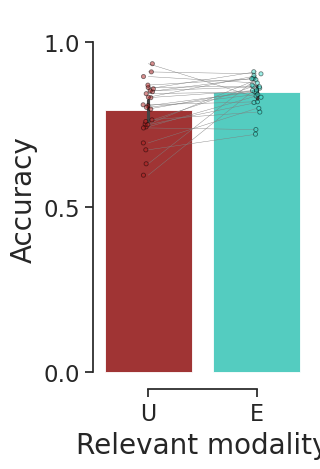

In [16]:
dat = df.groupby(["id", "relevant_expected"], as_index=0)["correct"].mean()
sizeplot = {}; sizeplot["height"] = 5; sizeplot["aspect"] = .7
axislabels = {}; axislabels["xlabel"] = 'Relevant modality'; axislabels["ylabel"]= "Accuracy"; axislabels["fontsize"]= 20; axislabels["xticks"] = ["U", "E"]; axislabels["rotation"] = 0
yaxis = {}; yaxis["yticks"]=[0, .5, 1]; yaxis["ylim"] = [-0.05,1.1]
dx = "relevant_expected"; dy = "correct"; hue = "relevant_expected";  row = None; col = None
pal = ["firebrick", "turquoise"]
barsplot(dat, dx, dy, dx, None, None, pal, pal, sizeplot, yaxis, axislabels, sizepoint = 3, dodge = False, lines = True)
dat.groupby("relevant_expected")["correct"].mean()
pg.rm_anova(dv="correct", within= ["relevant_expected"], subject='id', correction='auto', effsize = "np2", data=dat)

#plt.savefig("figures/exp1/att_accuracy.png", dpi=500, bbox_inches = 'tight')

### Reaction times

In [17]:
df.groupby(["relevant_expected"], as_index=0)["RT"].mean()

,relevant_expected,RT
0,0,0.593462
1,1,0.567416


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,pred,1,24,5.06107,0.033911,0.174153,1.0


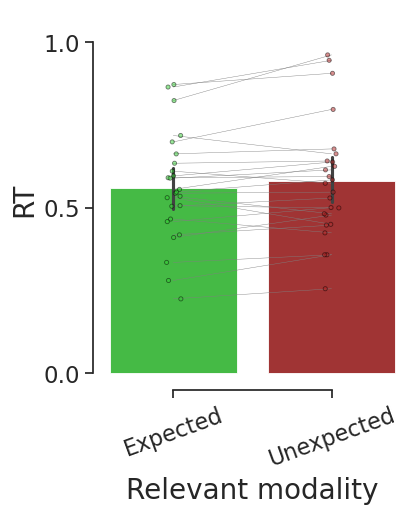

In [18]:
dat = df.groupby(["id", "pred"], as_index=0)["RT"].mean()
sizeplot = {}; sizeplot["height"] = 5; sizeplot["aspect"] = 0.9
axislabels = {}; axislabels["xlabel"] = 'Relevant modality'; axislabels["ylabel"]= "RT"; axislabels["fontsize"]= 20; axislabels["xticks"] = ["Expected", "Unexpected"]; axislabels["rotation"] = 20
yaxis = {}; yaxis["yticks"]=[0, .5, 1]; yaxis["ylim"] = [-0.05,1.1]
dx = "pred"; dy = "RT"; hue = "pred";  row = None; col = None
pal = ["limegreen", "firebrick"]
barsplot(dat, dx, dy, dx, None, None, pal, pal, sizeplot, yaxis, axislabels, sizepoint = 3, dodge = False, lines = True)
pg.rm_anova(dv="RT", within= ["pred"], subject='id', correction='auto', effsize = "np2", data=dat)
#dat.groupby("pred")["RT"].mean()

#plt.savefig("figures/exp1/3reps/attEXP_accuracy.png", dpi=500)

## Irrelevant modality predictions

### Accuracy

In [19]:
df.groupby(["irrelevant_expected"], as_index=0)["correct"].mean()

,irrelevant_expected,correct
0,0,0.788321
1,1,0.820141


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,irrelevant_expected,1,24,13.18682,0.00133,0.35461,1.0


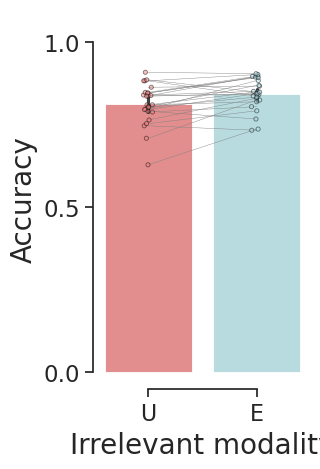

In [19]:
dat = df.groupby(["id", "irrelevant_expected"], as_index=0)["correct"].mean()
sizeplot = {}; sizeplot["height"] = 5; sizeplot["aspect"] = .7
axislabels = {}; axislabels["xlabel"] = 'Irrelevant modality'; axislabels["ylabel"]= "Accuracy"; axislabels["fontsize"]= 20; axislabels["xticks"] = ["U", "E"]; axislabels["rotation"] = 0
yaxis = {}; yaxis["yticks"]=[0, .5, 1]; yaxis["ylim"] = [-0.05,1.1]
dx = "irrelevant_expected"; dy = "correct"; hue = "irrelevant_expected";  row = None; col = None
pal = ["lightcoral", "powderblue"]
barsplot(dat, dx, dy, dx, None, None, pal, pal, sizeplot, yaxis, axislabels, sizepoint = 3, dodge = False, lines = True)
pg.rm_anova(dv="correct", within= ["irrelevant_expected"], subject='id', correction='auto', effsize = "np2", data=dat)

#plt.savefig("figures/exp1/unatt_accuracy.png", dpi=500)

### Reaction times

In [20]:
df.groupby(["irrelevant_expected"], as_index=0)["RT"].mean()

,irrelevant_expected,RT
0,0,0.595331
1,1,0.566745


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,ign_pred,1,24,11.409472,0.00249,0.322215,1.0


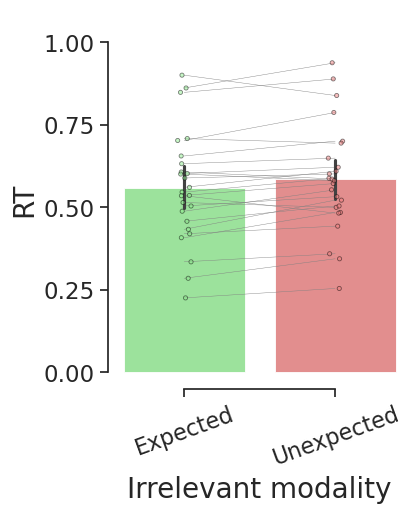

In [21]:
dat = df.groupby(["id", "ign_pred"], as_index=0)["RT"].mean()
sizeplot = {}; sizeplot["height"] = 5; sizeplot["aspect"] = 0.9
axislabels = {}; axislabels["xlabel"] = 'Irrelevant modality'; axislabels["ylabel"]= "RT"; axislabels["fontsize"]= 20; axislabels["xticks"] = ["Expected", "Unexpected"]; axislabels["rotation"] = 20
yaxis = {}; yaxis["yticks"]=[0, .25, .5, .75, 1]; yaxis["ylim"] = [-0.05,1.1]
dx = "ign_pred"; dy = "RT"; hue = "ign_pred";  row = None; col = None
pal = ["lightgreen", "lightcoral"]
barsplot(dat, dx, dy, dx, None, None, pal, pal, sizeplot, yaxis, axislabels, sizepoint = 3, dodge = False, lines = True)
pg.rm_anova(dv="RT", within= ["ign_pred"], subject='id', correction='auto', effsize = "np2", data=dat)
#dat.groupby("ign_pred")["RT"].mean()
#plt.savefig("figures/exp1/3reps/attEXP_accuracy.png", dpi=500)

# Question 2: how does this happen? Changes on sensitivity and bias

## Relevant

In [23]:
dat = df.groupby(["id", "relevant_expected", "modality"]).apply(dprime, "target", 1, "diferente").reset_index(); dat
pg.rm_anova(data=dat, dv = "c", within=["relevant_expected", "modality"], subject="id")

/tmp/ipykernel_10303/831295044.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dat = df.groupby(["id", "relevant_expected", "modality"]).apply(dprime, "target", 1, "diferente").reset_index(); dat


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,relevant_expected,0.600807,1,14,0.600807,6.676426,0.021646,0.021646,0.069507,1.0
1,modality,0.038534,1,14,0.038534,0.220545,0.645856,0.645856,0.004768,1.0
2,relevant_expected * modality,0.044250,1,14,0.044250,0.414029,0.530331,0.530331,0.005472,1.0


In [25]:
relevant_change = Lmer("response ~ change * relevant_expected + (1 + change|id)", data = df, family="binomial") 
relevant_change.fit(factors={**relevant_expected})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~change*relevant_expected+(1+change|id)

Family: binomial	 Inference: parametric

Number of observations: 12118	 Groups: {'id': 25.0}

Log-likelihood: -5388.259 	 AIC: 10790.518

Random effects:

           Name    Var    Std
id  (Intercept)  0.221  0.470
id       change  1.493  1.222

            IV1     IV2   Corr
id  (Intercept)  change -0.595

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.506,-1.731,-1.282,0.115,0.222,0.177,0.278,0.181,0.150,0.217,-13.137,0.0,***
change,3.744,3.206,4.281,0.274,42.254,24.690,72.312,0.977,0.961,0.986,13.656,0.0,***
relevant_expected1,-0.646,-0.789,-0.502,0.073,0.524,0.454,0.605,0.344,0.312,0.377,-8.834,0.0,***
change:relevant_expected1,0.684,0.418,0.950,0.136,1.982,1.518,2.587,0.665,0.603,0.721,5.033,0.0,***


In [9]:
# This list of models is used to compare the AIC and BIC of the models
# They are not stored here as they take up a lot of space. To run the following code, fit each model and store them using:
#save_model(<model name>, "models/exp1/<output name>.joblib")

# # Load models
# relevant_change1 = load_model("models/exp1/exp1_relevantchange1.joblib") # response ~ change * relevant_expected + (1|id)
# relevant_change2 = load_model("models/exp1/exp1_relevantchange2.joblib") # response ~ change * relevant_expected + (1 + change|id)
# relevant_change3 = load_model("models/exp1/exp1_relevantchange3.joblib") # response ~ change * relevant_expected + modality + (1|id)
# relevant_change4 = load_model("models/exp1/exp1_relevantchange4.joblib") # response ~ change * relevant_expected + modality + (1 + change|id)
# relevant_change5 = load_model("models/exp1/exp1_relevantchange5.joblib") # response ~ change * relevant_expected * modality + (1 + change|id)  !!!  Model failed to converge with max|grad| = 0.00504114 (tol = 0.002, component 1)
# relevant_change6 = load_model("models/exp1/exp1_relevantchange6.joblib") # response ~ change * relevant_expected + modality + (1 + change + modality|id)
# relevant_change7 = load_model("models/exp1/exp1_relevantchange7.joblib") # response ~ change * relevant_expected * modality + (1 + change + modality|id)
# relevant_change8 = load_model("models/exp1/exp1_relevantchange8.joblib") # response ~ change * relevant_expected * modality + (1 + change * modality|id)  !!!  Failed to converge

# # Compare models
# reportAIC([relevant_change1, relevant_change2, relevant_change3, relevant_change4, relevant_change5, relevant_change6, relevant_change7, relevant_change8])

# # Best model that converges is model 7: response~change*relevant_expected*modality+(1+change+modality|id)   AIC: 10536.955434879972 ||  BIC: 10640.58969609304
# # But using model 2 for interpretability and comparability with unattended GLMM

Model 0: response~change*relevant_expected+(1|id)   AIC: 11028.289402496706 ||  BIC: 11065.30163864423
Model 1: response~change*relevant_expected+(1+change|id)   AIC: 10790.518055052042 ||  BIC: 10842.335185658576
Model 2: response~change*relevant_expected+modality+(1|id)   AIC: 10996.664012897934 ||  BIC: 11041.078696274964
Model 3: response~change*relevant_expected+modality+(1+change|id)   AIC: 10755.491094825706 ||  BIC: 10814.710672661746
Model 4: response~change*relevant_expected*modality+(1+change|id)   AIC: 10658.475005033972 ||  BIC: 10739.901924558526
Model 5: response~change*relevant_expected+modality+(1+change+modality|id)   AIC: 10572.358931265333 ||  BIC: 10653.785850789887
Model 6: response~change*relevant_expected*modality+(1+change+modality|id)   AIC: 10536.955434879972 ||  BIC: 10640.58969609304
Model 7: response~change*relevant_expected*modality+(1+change*modality|id)   AIC: 10471.96057925643 ||  BIC: 10605.20462938752


### Plot curves

/home/wiseman/miniconda3/envs/pymer4/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


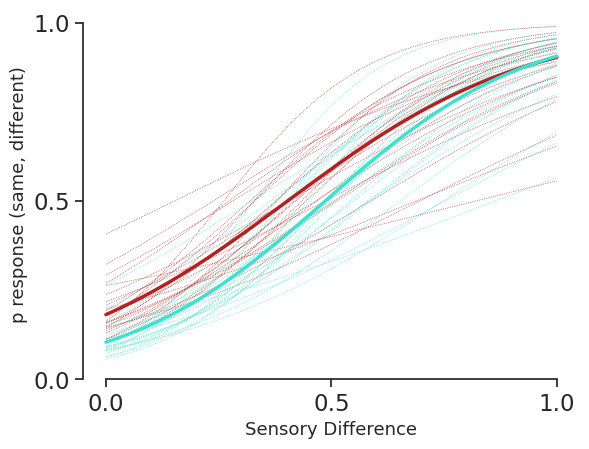

In [27]:
change_vals = np.repeat(np.linspace(0,1,100), 2)
pred_vals = ["0","1"] * 100
response_vals = [""]*200



dat_avg = pd.DataFrame({"id": ["avg"]*200, "change":change_vals, "relevant_expected":pred_vals, "response":response_vals}) # Artificial df to make prediction without rfx
dat_avg["fits"] = relevant_change.predict(dat_avg, use_rfx=False, pred_type='response', skip_data_checks=True, verify_predictions=False, verbose=False)

dat = pd.DataFrame({"id": [],"change":[], "relevant_expected":[], "response":[]})
for id in df["id"].unique(): # Artificial dataframe for each subject
    dat = pd.concat([dat, pd.DataFrame({"id": [id]*200, "change":change_vals, "relevant_expected":pred_vals, "response":response_vals})])
dat["fits"] = relevant_change.predict(dat, use_rfx=True, pred_type='response', skip_data_checks=True, verify_predictions=False, verbose=False) # Predict fits for each subject


ax = plt.subplots()

for id in dat["id"].unique(): # Plotting individual curves
    ax = sns.lineplot(y="fits", x="change", hue = "relevant_expected", linewidth = .5, linestyle = "dotted", palette = ["firebrick", "turquoise"], hue_order = ["0","1"], data = dat[dat.id==id], legend=False) 

# Plotting avg curve
ax = sns.lineplot(y="fits", x="change", hue = "relevant_expected", linewidth = 2.5, palette = ["firebrick", "turquoise"], hue_order = ["0","1"], data = dat_avg, legend=False) 

plt.xlabel("Sensory Difference", fontsize = 13)
plt.ylabel("p response (same, different)", fontsize = 13)
#ax.set(xlabel="Sensory Difference", ylabel="p response (same, different)", fontsize = 15)
ax.set(xticks=[0, 0.5, 1], yticks=[0, .5, 1])
sns.despine(trim=True)
#plt.savefig("figures/exp1/att_curve_raw.png", dpi=500)

### Plot estimates

In [28]:
model_estimates = relevant_change.post_hoc(marginal_vars="change", grouping_vars="relevant_expected")[0] # Marginal effects of expectation on change (slopes)

# Intercept estimate and confidence intervals for unexpected trials
unexpected_intercept = {"relevant_expected": 0}
unexpected_intercept["Estimate"] = relevant_change.coefs["Estimate"]["(Intercept)"]
unexpected_intercept["2.5_ci"] = relevant_change.coefs["2.5_ci"]["(Intercept)"]
unexpected_intercept["97.5_ci"] =  relevant_change.coefs["97.5_ci"]["(Intercept)"]
model_estimates = pd.concat([model_estimates, pd.DataFrame(unexpected_intercept, index=[3])])

# Intercept estimate and confidence intervals for expected trials
expected_intercept = {"relevant_expected": 1}
expected_intercept["Estimate"] = relevant_change.coefs["Estimate"]["(Intercept)"] + relevant_change.coefs["Estimate"]["relevant_expected1"] # Intercept value in relation to reference 
expected_intercept["2.5_ci"] = expected_intercept["Estimate"] + relevant_change.coefs["SE"]["relevant_expected1"] * -1.96 # Using SE to find 2.5CI below intercept mean estimate
expected_intercept["97.5_ci"] = expected_intercept["Estimate"] + relevant_change.coefs["SE"]["relevant_expected1"] * 1.96
model_estimates = pd.concat([model_estimates, pd.DataFrame(expected_intercept, index=[4])])

model_estimates["Relevant stimulus"] = ["EXP","UEXP","EXP","UEXP"]
errors = model_estimates['Estimate'] - model_estimates["2.5_ci"]; model_estimates["errors"] = errors

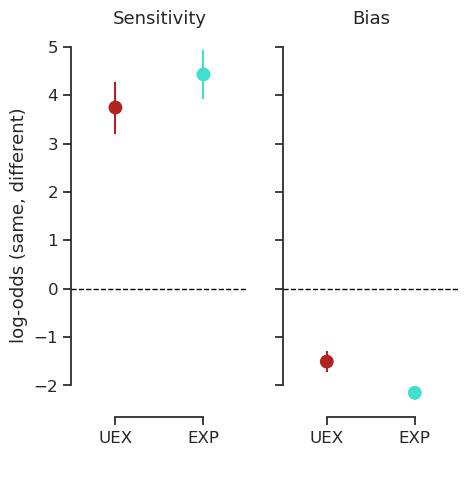

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
model_estimates[0:2].plot(x="Relevant stimulus", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(model_estimates[0:2].shape[0]),
            marker='o', s=80, 
            y=model_estimates[0:2]['Estimate'],
            color=["firebrick", "turquoise"])


model_estimates[2:4].plot(x="Relevant stimulus", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(model_estimates[2:4].shape[0]),
            marker='o', s=80, 
            y=model_estimates[2:4]['Estimate'],
            color=["firebrick", "turquoise"])

ax[0].set_ylabel("log-odds (same, different)", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title("Sensitivity", fontsize=13)
ax[1].set_title("Bias", fontsize=13)
ax[1].set_xlabel(" ")
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].axhline(y=0, linestyle='--', color='black', linewidth=1)
ax[1].axhline(y=0, linestyle='--', color='black', linewidth=1)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)

#plt.savefig("figures/exp1/att_estimates_raw.png", dpi=500)

### Controlling for modality. Separate model for auditory and visual

In [30]:
relevant_visual = Lmer("response ~ change * relevant_expected + (1 + change|id)", data = df[df.modality=="visual"], family="binomial") 
relevant_visual.fit(factors={**relevant_expected})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~change*relevant_expected+(1+change|id)

Family: binomial	 Inference: parametric

Number of observations: 7743	 Groups: {'id': 25.0}

Log-likelihood: -3006.632 	 AIC: 6027.263

Random effects:

           Name    Var    Std
id  (Intercept)  0.233  0.483
id       change  1.686  1.298

            IV1     IV2   Corr
id  (Intercept)  change -0.801

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.809,-2.069,-1.550,0.132,0.164,0.126,0.212,0.141,0.112,0.175,-13.681,0.000,***
change,4.330,3.731,4.929,0.306,75.954,41.717,138.288,0.987,0.977,0.993,14.163,0.000,***
relevant_expected1,-0.655,-0.861,-0.449,0.105,0.519,0.423,0.638,0.342,0.297,0.390,-6.237,0.000,***
change:relevant_expected1,0.519,0.156,0.881,0.185,1.680,1.169,2.414,0.627,0.539,0.707,2.805,0.005,**


In [31]:
relevant_auditory = Lmer("response ~ change * relevant_expected + (1 + change|id)", data = df[df.modality=="auditory"], family="binomial") 
relevant_auditory.fit(factors={**relevant_expected})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~change*relevant_expected+(1+change|id)

Family: binomial	 Inference: parametric

Number of observations: 4375	 Groups: {'id': 15.0}

Log-likelihood: -2213.622 	 AIC: 4441.243

Random effects:

           Name     Var    Std
id  (Intercept)   0.190  0.436
id       change  15.178  3.896

            IV1     IV2   Corr
id  (Intercept)  change  0.047

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.090,-1.378,-0.801,0.147,0.336,0.252,0.449,0.252,0.201,0.310,-7.397,0.0,***
change,3.838,1.802,5.874,1.039,46.421,6.060,355.572,0.979,0.858,0.997,3.694,0.0,***
relevant_expected1,-0.605,-0.818,-0.393,0.109,0.546,0.441,0.675,0.353,0.306,0.403,-5.577,0.0,***
change:relevant_expected1,0.875,0.460,1.290,0.212,2.399,1.584,3.634,0.706,0.613,0.784,4.132,0.0,***


## Irrelevant

In [32]:
dat = df.groupby(["id", "irrelevant_expected", "modality"]).apply(dprime, "target", 1, "diferente").reset_index(); dat
pg.rm_anova(data=dat, dv = "c", within=["irrelevant_expected", "modality"], subject="id")

/tmp/ipykernel_10303/2064276477.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dat = df.groupby(["id", "irrelevant_expected", "modality"]).apply(dprime, "target", 1, "diferente").reset_index(); dat


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,irrelevant_expected,0.126880,1,14,0.126880,6.112408,0.026864,0.026864,0.028706,1.0
1,modality,0.095533,1,14,0.095533,0.743431,0.403092,0.403092,0.021768,1.0
2,irrelevant_expected * modality,0.000058,1,14,0.000058,0.001954,0.965368,0.965368,0.000013,1.0


In [39]:
irrelevant_change = Lmer("response ~ change * irrelevant_expected + (1 + change|id)", data = df, family="binomial") 
irrelevant_change.fit(factors={**irrelevant_expected})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~change*irrelevant_expected+(1+change|id)

Family: binomial	 Inference: parametric

Number of observations: 12118	 Groups: {'id': 25.0}

Log-likelihood: -5417.931 	 AIC: 10849.862

Random effects:

           Name    Var    Std
id  (Intercept)  0.217  0.466
id       change  1.492  1.222

            IV1     IV2   Corr
id  (Intercept)  change -0.589

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.759,-1.988,-1.531,0.117,0.172,0.137,0.216,0.147,0.120,0.178,-15.079,0.000,***
change,4.046,3.505,4.586,0.276,57.155,33.295,98.114,0.983,0.971,0.990,14.675,0.000,***
irrelevant_expected1,-0.302,-0.452,-0.153,0.076,0.739,0.637,0.858,0.425,0.389,0.462,-3.968,0.000,***
change:irrelevant_expected1,0.280,0.008,0.551,0.139,1.322,1.008,1.735,0.569,0.502,0.634,2.017,0.044,*


In [17]:

# # Load models
# irrelevant_change1 = load_model("models/exp1/exp1_irrelevantchange1.joblib") # response ~ change * irrelevant_expected + (1|id)
# irrelevant_change2 = load_model("models/exp1/exp1_irrelevantchange2.joblib") # response ~ change * irrelevant_expected + (1 + change|id)
# irrelevant_change3 = load_model("models/exp1/exp1_irrelevantchange3.joblib") # response ~ change * irrelevant_expected + modality + (1|id)
# irrelevant_change4 = load_model("models/exp1/exp1_irrelevantchange4.joblib") # response ~ change * irrelevant_expected + modality + (1 + change|id)
# irrelevant_change5 = load_model("models/exp1/exp1_irrelevantchange5.joblib") # response ~ change * irrelevant_expected * modality + (1 + change|id)  
# irrelevant_change6 = load_model("models/exp1/exp1_irrelevantchange6.joblib") # response ~ change * irrelevant_expected + modality + (1 + change + modality|id)
# irrelevant_change7 = load_model("models/exp1/exp1_irrelevantchange7.joblib") # response ~ change * irrelevant_expected * modality + (1 + change + modality|id)  !!!  Model failed to converge with max|grad| = 0.00242652 (tol = 0.002, component 1)
# irrelevant_change8 = load_model("models/exp1/exp1_irrelevantchange8.joblib") # response ~ change * irrelevant_expected * modality + (1 + change * modality|id)  !!!  Model failed to converge with max|grad| = 0.00314528 (tol = 0.002, component 1) 


# # Compare models
# reportAIC([irrelevant_change1, irrelevant_change2, irrelevant_change3, irrelevant_change4, irrelevant_change5, irrelevant_change6, irrelevant_change7, irrelevant_change8])

# # Best model that converges is model 7: response~change*relevant_expected*modality+(1+change+modality|id)   AIC: 10536.955434879972 ||  BIC: 10640.58969609304


Model 0: response~change*irrelevant_expected+(1|id)   AIC: 11088.515061547838 ||  BIC: 11125.527297695362
Model 1: response~change*irrelevant_expected+(1+change|id)   AIC: 10849.861704375124 ||  BIC: 10901.678834981658
Model 2: response~change*irrelevant_expected+modality+(1|id)   AIC: 11056.533493466242 ||  BIC: 11100.948176843272
Model 3: response~change*irrelevant_expected+modality+(1+change|id)   AIC: 10814.392728199602 ||  BIC: 10873.612306035642
Model 4: response~change*irrelevant_expected*modality+(1+change|id)   AIC: 10720.6130525636 ||  BIC: 10802.039972088154
Model 5: response~change*irrelevant_expected+modality+(1+change+modality|id)   AIC: 10630.542819929507 ||  BIC: 10711.969739454062
Model 6: response~change*irrelevant_expected*modality+(1+change+modality|id)   AIC: 10598.460647497923 ||  BIC: 10702.094908710991
Model 7: response~change*irrelevant_expected*modality+(1+change*modality|id)   AIC: 10531.437661892653 ||  BIC: 10664.681712023741


In [40]:
irrelevant_change.post_hoc(marginal_vars="change", grouping_vars="irrelevant_expected")

(  irrelevant_expected  Estimate  2.5_ci  97.5_ci     SE   DF
 1                   0     4.046   3.505    4.586  0.276  inf
 2                   1     4.325   3.816    4.835  0.260  inf,
                                       Contrast  Estimate  2.5_ci  97.5_ci  \
 1  irrelevant_expected0 - irrelevant_expected1     -0.28  -0.551   -0.008   
 
       SE   DF  Z-stat  P-val Sig  
 1  0.139  inf  -2.017  0.044   *  )

### Plot curves

/home/wiseman/miniconda3/envs/pymer4/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


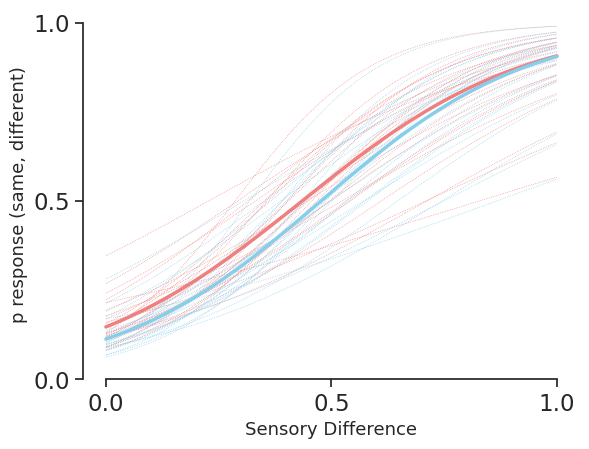

In [41]:
change_vals = np.repeat(np.linspace(0,1,100), 2)
pred_vals = ["0","1"] * 100
response_vals = [""]*200



dat_avg = pd.DataFrame({"id": ["avg"]*200, "change":change_vals, "irrelevant_expected":pred_vals, "response":response_vals}) # Artificial df to make prediction without rfx
dat_avg["fits"] = irrelevant_change.predict(dat_avg, use_rfx=False, pred_type='response', skip_data_checks=True, verify_predictions=False, verbose=False)

dat = pd.DataFrame({"id": [],"change":[], "relevant_expected":[], "response":[]})
for id in df["id"].unique(): # Artificial dataframe for each subject
    dat = pd.concat([dat, pd.DataFrame({"id": [id]*200, "change":change_vals, "irrelevant_expected":pred_vals,  "response":response_vals})])
dat["fits"] = irrelevant_change.predict(dat, use_rfx=True, pred_type='response', skip_data_checks=True, verify_predictions=False, verbose=False) # Predict fits for each subject


ax = plt.subplots()

for id in dat["id"].unique(): # Plotting individual curves
    ax = sns.lineplot(y="fits", x="change", hue = "irrelevant_expected", linewidth = .5, linestyle = "dotted", palette = ["lightcoral", "skyblue"], hue_order = ["0","1"], data = dat[dat.id==id], legend=False) 

# Plotting avg curve
ax = sns.lineplot(y="fits", x="change", hue = "irrelevant_expected", linewidth = 2.5, palette = ["lightcoral", "skyblue"], hue_order = ["0","1"], data = dat_avg, legend=False) 

plt.xlabel("Sensory Difference", fontsize = 13)
plt.ylabel("p response (same, different)", fontsize = 13)
#ax.set(xlabel="Sensory Difference", ylabel="p response (same, different)", fontsize = 15)
ax.set(xticks=[0, 0.5, 1], yticks=[0, .5, 1])
sns.despine(trim=True)
#plt.savefig("figures/exp1/ign_curve_raw.png", dpi=500)

### Plot estimates

In [42]:
model_estimates = irrelevant_change.post_hoc(marginal_vars="change", grouping_vars="irrelevant_expected")[0] # Marginal effects of expectation on change (slopes)

# Intercept estimate and confidence intervals for unexpected trials
unexpected_intercept = {"irrelevant_expected": 0}
unexpected_intercept["Estimate"] = irrelevant_change.coefs["Estimate"]["(Intercept)"]
unexpected_intercept["2.5_ci"] = irrelevant_change.coefs["2.5_ci"]["(Intercept)"]
unexpected_intercept["97.5_ci"] =  irrelevant_change.coefs["97.5_ci"]["(Intercept)"]
model_estimates = pd.concat([model_estimates, pd.DataFrame(unexpected_intercept, index=[3])])

# Intercept estimate and confidence intervals for expected trials
expected_intercept = {"irrelevant_expected": 1}
expected_intercept["Estimate"] = irrelevant_change.coefs["Estimate"]["(Intercept)"] + irrelevant_change.coefs["Estimate"]["irrelevant_expected1"] # Intercept value in relation to reference 
expected_intercept["2.5_ci"] = expected_intercept["Estimate"] + irrelevant_change.coefs["SE"]["irrelevant_expected1"] * -1.96 # Using SE to find 2.5CI below intercept mean estimate
expected_intercept["97.5_ci"] = expected_intercept["Estimate"] + irrelevant_change.coefs["SE"]["irrelevant_expected1"] * 1.96
model_estimates = pd.concat([model_estimates, pd.DataFrame(expected_intercept, index=[4])])

model_estimates["Irrelevant stimulus"] = ["EXP","UEXP","EXP","UEXP"]
errors = model_estimates['Estimate'] - model_estimates["2.5_ci"]; model_estimates["errors"] = errors

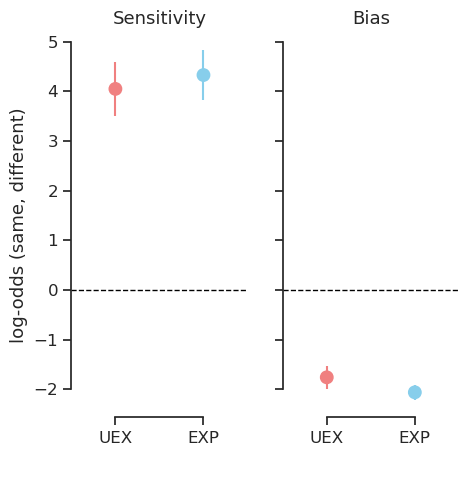

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
model_estimates[0:2].plot(x="Irrelevant stimulus", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["lightcoral", "skyblue"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(model_estimates[0:2].shape[0]),
            marker='o', s=80, 
            y=model_estimates[0:2]['Estimate'],
            color=["lightcoral", "skyblue"])


model_estimates[2:4].plot(x="Irrelevant stimulus", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["lightcoral", "skyblue"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(model_estimates[2:4].shape[0]),
            marker='o', s=80, 
            y=model_estimates[2:4]['Estimate'],
            color=["lightcoral", "skyblue"])

ax[0].set_ylabel("log-odds (same, different)", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title("Sensitivity", fontsize=13)
ax[1].set_title("Bias", fontsize=13)
ax[1].set_xlabel(" ")
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].axhline(y=0, linestyle='--', color='black', linewidth=1)
ax[1].axhline(y=0, linestyle='--', color='black', linewidth=1)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)

#plt.savefig("figures/exp1/ign_estimates_raw.png", dpi=500)

### Controling for modality

In [22]:
irrelevant_visual = Lmer("response ~ change * irrelevant_expected + (1 + change|id)", data = df[df.modality=="visual"], family="binomial") 
irrelevant_visual.fit(factors={**irrelevant_expected})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~change*irrelevant_expected+(1+change|id)

Family: binomial	 Inference: parametric

Number of observations: 7745	 Groups: {'id': 25.0}

Log-likelihood: -3049.997 	 AIC: 6113.993

Random effects:

           Name    Var    Std
id  (Intercept)  0.248  0.498
id       change  2.116  1.455

            IV1     IV2   Corr
id  (Intercept)  change -0.548

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-2.186,-2.465,-1.907,0.142,0.112,0.085,0.149,0.101,0.078,0.129,-15.348,0.000,***
change,4.797,4.131,5.463,0.340,121.157,62.266,235.748,0.992,0.984,0.996,14.124,0.000,***
irrelevant_expected1,-0.130,-0.350,0.090,0.112,0.878,0.704,1.094,0.467,0.413,0.523,-1.158,0.247,
change:irrelevant_expected1,0.020,-0.354,0.394,0.191,1.020,0.702,1.483,0.505,0.412,0.597,0.106,0.916,


In [23]:
irrelevant_auditory = Lmer("response ~ change * irrelevant_expected + (1 + change|id)", data = df[df.modality=="auditory"], family="binomial") 
irrelevant_auditory.fit(factors={**irrelevant_expected})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~change*irrelevant_expected+(1+change|id)

Family: binomial	 Inference: parametric

Number of observations: 7550	 Groups: {'id': 25.0}

Log-likelihood: -3929.336 	 AIC: 7872.672

Random effects:

           Name    Var    Std
id  (Intercept)  0.245  0.495
id       change  9.036  3.006

            IV1     IV2   Corr
id  (Intercept)  change -0.167

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.215,-1.458,-0.972,0.124,0.297,0.233,0.378,0.229,0.189,0.274,-9.805,0.000,***
change,3.788,2.561,5.015,0.626,44.174,12.954,150.632,0.978,0.928,0.993,6.052,0.000,***
irrelevant_expected1,-0.299,-0.463,-0.135,0.084,0.741,0.629,0.873,0.426,0.386,0.466,-3.579,0.000,***
change:irrelevant_expected1,0.364,0.041,0.687,0.165,1.439,1.042,1.987,0.590,0.510,0.665,2.212,0.027,*


# **Question 3**: Do relevant and irrelevant predictions interact?
The anova on accuracy reveals a significant interaction which can be explained as a difference in irrelevant exp vs uexp only when the relevant modality is expected

## Accuracy

In [44]:
dat = df.groupby(["id", "relevant_expected", "irrelevant_expected"], as_index=0)["correct"].mean()
pg.rm_anova(dv="correct", within= ["relevant_expected", "irrelevant_expected"], subject='id', correction='auto', effsize = "np2", data=dat)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,relevant_expected,0.046037,1,24,0.046037,6.909607,0.014719,0.014719,0.223542,1.0
1,irrelevant_expected,0.001170,1,24,0.001170,0.554059,0.463890,0.463890,0.022565,1.0
2,relevant_expected * irrelevant_expected,0.016749,1,24,0.016749,9.231182,0.005665,0.005665,0.277787,1.0


In [51]:
interaction_model = Lmer("correct ~ relevant_expected * irrelevant_expected * modality + (1|id)", data = df, family="binomial") 
interaction_model.fit(factors={**relevant_expected, **irrelevant_expected, **modality})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct~relevant_expected*irrelevant_expected*modality+(1|id)

Family: binomial	 Inference: parametric

Number of observations: 12118	 Groups: {'id': 25.0}

Log-likelihood: -5449.050 	 AIC: 10916.099

Random effects:

           Name    Var    Std
id  (Intercept)  0.063  0.251

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.022,0.805,1.240,0.111,2.779,2.236,3.454,0.735,0.691,0.775,9.217,0.000,***
relevant_expected1,0.176,-0.096,0.447,0.138,1.192,0.909,1.563,0.544,0.476,0.610,1.268,0.205,
irrelevant_expected1,-0.088,-0.352,0.177,0.135,0.916,0.703,1.193,0.478,0.413,0.544,-0.649,0.516,
modality1,0.617,0.360,0.874,0.131,1.854,1.433,2.397,0.650,0.589,0.706,4.701,0.000,***
relevant_expected1:irrelevant_expected1,0.382,0.039,0.724,0.175,1.465,1.040,2.063,0.594,0.510,0.673,2.185,0.029,*
relevant_expected1:modality1,-0.100,-0.465,0.264,0.186,0.905,0.628,1.302,0.475,0.386,0.566,-0.539,0.590,
irrelevant_expected1:modality1,-0.064,-0.418,0.290,0.181,0.938,0.659,1.337,0.484,0.397,0.572,-0.352,0.725,
relevant_expected1:irrelevant_expected1:modality1,-0.015,-0.473,0.443,0.234,0.985,0.623,1.558,0.496,0.384,0.609,-0.064,0.949,


In [49]:

# # Load models
# interaction_model1 = load_model("models/exp1/exp1_interaction1.joblib") # correct ~ relevant_expected * irrelevant_expected + (1|id)
# interaction_model2 = load_model("models/exp1/exp1_interaction2.joblib") # correct ~ relevant_expected * irrelevant_expected + modality + (1|id)
# interaction_model3 = load_model("models/exp1/exp1_interaction3.joblib") # correct ~ relevant_expected * irrelevant_expected * modality + (1|id)
# interaction_model4 = load_model("models/exp1/exp1_interaction4.joblib") # correct ~ relevant_expected * irrelevant_expected + modality + (1 + modality|id)
# interaction_model5 = load_model("models/exp1/exp1_interaction5.joblib") # correct ~ relevant_expected * irrelevant_expected * modality + (1 + modality|id)
# interaction_model6 = load_model("models/exp1/exp1_interaction6.joblib") # correct ~ relevant_expected * irrelevant_expected * modality + (1 * modality|id)

# # Compare models
# reportAIC([interaction_model1, interaction_model2, interaction_model3, interaction_model4, interaction_model5, interaction_model6])

# # Best model is model 4: correct~relevant_expected*irrelevant_expected+modality+(1+modality|id)   AIC: 10914.492596857026 ||  BIC: 10973.712174693066
# # But model 3 is easier to interpret + doesn't include random effect of modality + demonstrate absence of interaction


In [52]:
interaction_model.post_hoc(marginal_vars="irrelevant_expected", grouping_vars="relevant_expected")

(  irrelevant_expected relevant_expected  Estimate  2.5_ci  97.5_ci     SE   DF
 1                   0                 0     1.331   1.168    1.493  0.083  inf
 2                   1                 0     1.211   1.051    1.371  0.082  inf
 3                   0                 1     1.456   1.290    1.622  0.085  inf
 4                   1                 1     1.711   1.591    1.831  0.061  inf,
                                       Contrast relevant_expected  Estimate  \
 1  irrelevant_expected0 - irrelevant_expected1                 0     0.119   
 2  irrelevant_expected0 - irrelevant_expected1                 1    -0.255   
 
    2.5_ci  97.5_ci     SE   DF  Z-stat  P-val  Sig  
 1  -0.058    0.296  0.090  inf   1.322  0.186       
 2  -0.401   -0.109  0.074  inf  -3.430  0.001  ***  )

### Plotting estimates

In [47]:
dat = interaction_model.post_hoc(marginal_vars="irrelevant_expected", grouping_vars="relevant_expected")[0]
errors = dat['Estimate'] - dat["2.5_ci"]; dat["errors"] = errors


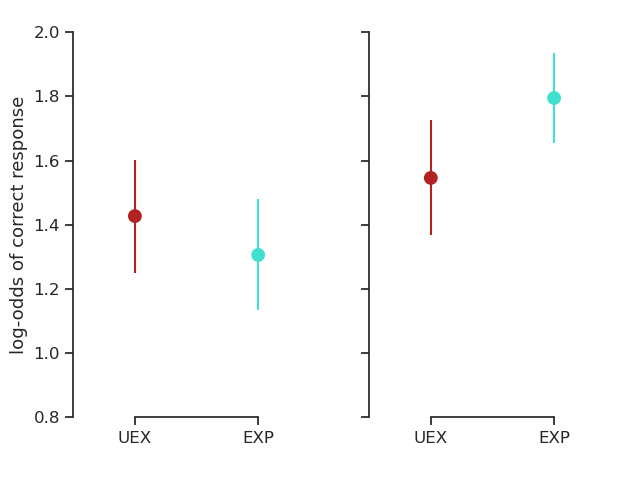

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharey=True)
dat[0:2].plot(x="relevant_expected", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(dat[0:2].shape[0]),
            marker='o', s=80, 
            y=dat[0:2]['Estimate'],
            color=["firebrick", "turquoise"])


dat[2:4].plot(x="relevant_expected", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(dat[2:4].shape[0]),
            marker='o', s=80, 
            y=dat[2:4]['Estimate'],
            color=["firebrick", "turquoise"])

ax[0].set_ylabel("log-odds of correct response", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title(" ", fontsize=13)
ax[1].set_title(" ", fontsize=13)
ax[1].set_xlabel(" ")
ax[0].set(ylim=[.8, 2])
ax[1].set(ylim=[.8, 2])
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)
#plt.savefig("figures/exp1/interaction_estimates.png", dpi=500, bbox_inches='tight')

# Question 4: Is explicit knowledge necessary for the prediction effects to emerge?

## Explicit recall phase

In [53]:
df.groupby(["modality"])["id"].nunique()

modality
auditory    15
visual      25
Name: id, dtype: int64

In [56]:
df_explicit = pd.read_csv("data/exp1_explicit.csv")
dat = df_explicit[df_explicit.modality == "visual"]
k = dat["correct"].sum() # Number of correct recalls
n = len(dat) ; # Number of trials
stats.binomtest(k, n, p=0.5, alternative="two-sided") # higher than chance

BinomTestResult(k=144, n=200, alternative='two-sided', statistic=0.72, pvalue=4.0153927932332665e-10)

In [58]:
df_explicit.groupby(["modality"])["correct"].mean()

modality
auditory    0.605
visual      0.720
Name: correct, dtype: float64

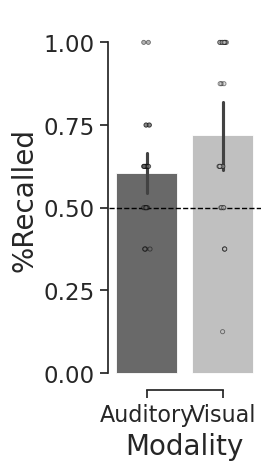

In [59]:
dat = df_explicit.groupby(["id", "modality"], as_index=0)["correct"].mean()
sizeplot = {}; sizeplot["height"] = 5; sizeplot["aspect"] = 0.6
axislabels = {}; axislabels["xlabel"] = 'Modality'; axislabels["ylabel"]= "%Recalled"; axislabels["fontsize"]= 20; axislabels["xticks"] = ["Auditory", "Visual"]; axislabels["rotation"] = 0
yaxis = {}; yaxis["yticks"]=[0, .25, .5, .75, 1]; yaxis["ylim"] = [-0.05,1.1]
dx = "modality"; dy = "correct"; hue = "modality";  row = None; col = None
pal = ["dimgray", "silver"]
barsplot(dat, dx, dy, dx, None, None, pal, pal, sizeplot, yaxis, axislabels, sizepoint = 3, dodge = False, lines = False)
plt.axhline(y=.5, linestyle='--', color='black', linewidth=1)
#plt.savefig("figures/exp1/recall_explicit.png", dpi=500, bbox_inches='tight')

## Relevant

In [62]:
att_learned_model = Lmer("correct ~ relevant_expected * att_learned * modality + (1|id)", data = df, family="binomial") 
att_learned_model.fit(factors={**relevant_expected, **att_learned, **modality})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct~relevant_expected*att_learned*modality+(1|id)

Family: binomial	 Inference: parametric

Number of observations: 12118	 Groups: {'id': 25.0}

Log-likelihood: -5443.804 	 AIC: 10905.608

Random effects:

           Name    Var    Std
id  (Intercept)  0.062  0.249

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.009,0.814,1.204,0.100,2.743,2.257,3.335,0.733,0.693,0.769,10.131,0.000,***
relevant_expected1,0.327,0.141,0.513,0.095,1.387,1.151,1.670,0.581,0.535,0.625,3.448,0.001,***
att_learned1,-0.123,-0.431,0.185,0.157,0.884,0.650,1.204,0.469,0.394,0.546,-0.781,0.435,
modality1,0.681,0.453,0.909,0.116,1.976,1.573,2.483,0.664,0.611,0.713,5.846,0.000,***
relevant_expected1:att_learned1,0.493,0.142,0.844,0.179,1.637,1.152,2.326,0.621,0.535,0.699,2.751,0.006,**
relevant_expected1:modality1,-0.199,-0.461,0.063,0.134,0.820,0.631,1.065,0.450,0.387,0.516,-1.486,0.137,
att_learned1:modality1,-0.177,-0.583,0.230,0.207,0.838,0.558,1.258,0.456,0.358,0.557,-0.852,0.394,
relevant_expected1:att_learned1:modality1,-0.003,-0.454,0.448,0.230,0.997,0.635,1.565,0.499,0.388,0.610,-0.015,0.988,


In [19]:
# # Load models
# att_learn1 = load_model("models/exp1/exp1_attlearn1.joblib") # correct ~ relevant_expected * att_learned + (1|id)
# att_learn2 = load_model("models/exp1/exp1_attlearn2.joblib") # correct ~ relevant_expected * att_learned + modality + (1|id)
# att_learn3 = load_model("models/exp1/exp1_attlearn3.joblib") # correct ~ relevant_expected * att_learned * modality + (1|id)
# att_learn4 = load_model("models/exp1/exp1_attlearn4.joblib") # correct ~ relevant_expected * att_learned + modality + (1 + modality|id)
# att_learn5 = load_model("models/exp1/exp1_attlearn5.joblib") # correct ~ relevant_expected * att_learned * modality + (1 + modality|id)

# # Compare models
# reportAIC([att_learn1, att_learn2, att_learn3, att_learn4, att_learn5])

# # Best model is model 2: correct~relevant_expected*att_learned+modality+(1|id)   AIC: 10904.50502144479 ||  BIC: 10948.91970482182
# # But model 3 allows control of modality 

Model 0: correct~relevant_expected*att_learned+(1|id)   AIC: 10986.769205216011 ||  BIC: 11023.781441363535
Model 1: correct~relevant_expected*att_learned+modality+(1|id)   AIC: 10904.50502144479 ||  BIC: 10948.91970482182
Model 2: correct~relevant_expected*att_learned*modality+(1|id)   AIC: 10905.608302882742 ||  BIC: 10972.230327948286
Model 3: correct~relevant_expected*att_learned+modality+(1+modality|id)   AIC: 10907.223633113503 ||  BIC: 10966.443210949543
Model 4: correct~relevant_expected*att_learned*modality+(1+modality|id)   AIC: 10908.355498513316 ||  BIC: 10989.78241803787


In [61]:
att_learned_model.coefs

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.435856,1.266663,1.605050,0.086325,4.203242,3.548990,4.978106,0.807812,0.780171,0.832723,16.633201,4.006110e-62,***
relevant_expected1,0.223825,0.093451,0.354199,0.066518,1.250852,1.097957,1.425038,0.555724,0.523346,0.587635,3.364856,7.658353e-04,***
att_learned1,-0.212889,-0.418672,-0.007105,0.104993,0.808246,0.657920,0.992920,0.446978,0.396835,0.498224,-2.027637,4.259732e-02,*
relevant_expected1:att_learned1,0.459112,0.242107,0.676118,0.110719,1.582669,1.273930,1.966230,0.612804,0.560233,0.662872,4.146641,3.373892e-05,***


In [63]:
att_learned_model.post_hoc(marginal_vars="relevant_expected", grouping_vars="att_learned")

(  relevant_expected att_learned  Estimate  2.5_ci  97.5_ci     SE   DF
 1                 0           0     1.350   1.192    1.508  0.081  inf
 2                 1           0     1.577   1.446    1.708  0.067  inf
 3                 0           1     1.139   0.953    1.324  0.095  inf
 4                 1           1     1.857   1.704    2.010  0.078  inf,
                                   Contrast att_learned  Estimate  2.5_ci  \
 1  relevant_expected0 - relevant_expected1           0    -0.227  -0.359   
 2  relevant_expected0 - relevant_expected1           1    -0.719  -0.902   
 
    97.5_ci     SE   DF  Z-stat  P-val  Sig  
 1   -0.096  0.067  inf  -3.395  0.001  ***  
 2   -0.535  0.094  inf  -7.665  0.000  ***  )

In [64]:
dat = att_learned_model.post_hoc(marginal_vars="relevant_expected", grouping_vars="att_learned")[0]
errors = dat['Estimate'] - dat["2.5_ci"]; dat["errors"] = errors


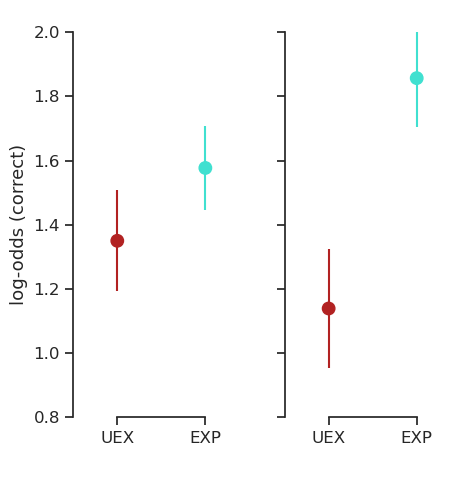

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
dat[0:2].plot(x="relevant_expected", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(dat[0:2].shape[0]),
            marker='o', s=80, 
            y=dat[0:2]['Estimate'],
            color=["firebrick", "turquoise"])


dat[2:4].plot(x="relevant_expected", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(dat[2:4].shape[0]),
            marker='o', s=80, 
            y=dat[2:4]['Estimate'],
            color=["firebrick", "turquoise"])

ax[0].set_ylabel("log-odds (correct)", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title(" ", fontsize=13)
ax[1].set_title(" ", fontsize=13)
ax[1].set_xlabel(" ")
ax[0].set(ylim=[.8, 2])
ax[1].set(ylim=[.8, 2])
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)
#plt.savefig("figures/exp1/att_recall.png", dpi=500, bbox_inches='tight')

## Unattended

In [68]:
ign_learned_model = Lmer("correct ~ irrelevant_expected * ign_learned * modality + (1|id)", data = df, family="binomial") 
ign_learned_model.fit(factors={**irrelevant_expected, **ign_learned, **modality})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct~irrelevant_expected*ign_learned*modality+(1|id)

Family: binomial	 Inference: parametric

Number of observations: 12118	 Groups: {'id': 25.0}

Log-likelihood: -5472.153 	 AIC: 10962.305

Random effects:

           Name    Var    Std
id  (Intercept)  0.062  0.248

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.143,0.951,1.336,0.098,3.138,2.589,3.802,0.758,0.721,0.792,11.667,0.000,***
irrelevant_expected1,0.217,0.035,0.398,0.092,1.242,1.036,1.488,0.554,0.509,0.598,2.344,0.019,*
ign_learned1,-0.160,-0.516,0.195,0.182,0.852,0.597,1.216,0.460,0.374,0.549,-0.884,0.377,
modality1,0.556,0.338,0.774,0.111,1.743,1.402,2.167,0.636,0.584,0.684,5.005,0.000,***
irrelevant_expected1:ign_learned1,0.287,-0.096,0.670,0.195,1.332,0.908,1.955,0.571,0.476,0.662,1.468,0.142,
irrelevant_expected1:modality1,-0.080,-0.325,0.164,0.125,0.923,0.722,1.179,0.480,0.419,0.541,-0.644,0.520,
ign_learned1:modality1,0.066,-0.391,0.524,0.233,1.069,0.676,1.689,0.517,0.403,0.628,0.284,0.776,
irrelevant_expected1:ign_learned1:modality1,-0.148,-0.653,0.358,0.258,0.863,0.520,1.431,0.463,0.342,0.589,-0.572,0.567,


In [31]:
# # Load models
# ign_learn1 = load_model("models/exp1/exp1_ignlearn1.joblib") # correct ~ irrelevant_expected * ign_learned + (1|id)
# ign_learn2 = load_model("models/exp1/exp1_ignlearn2.joblib") # correct ~ irrelevant_expected * ign_learned + modality + (1|id)
# ign_learn3 = load_model("models/exp1/exp1_ignlearn3.joblib") # correct ~ irrelevant_expected * ign_learned * modality + (1|id)
# ign_learn4 = load_model("models/exp1/exp1_ignlearn4.joblib") # correct ~ irrelevant_expected * ign_learned + modality + (1 + modality|id)
# ign_learn5 = load_model("models/exp1/exp1_ignlearn5.joblib") # correct ~ irrelevant_expected * ign_learned * modality + (1 + modality|id)

# # Compare models
# reportAIC([ign_learn1, ign_learn2, ign_learn3, ign_learn4, ign_learn5])

# # Best model is model 2: correct~irrelevant_expected*ign_learned+modality+(1|id)   AIC: 10957.793581120013 ||  BIC: 11002.208264497043
# # But model 3 allows control of modality and compare with attended model

Model 0: correct~irrelevant_expected*ign_learned+(1|id)   AIC: 11037.920972421998 ||  BIC: 11074.933208569522
Model 1: correct~irrelevant_expected*ign_learned+modality+(1|id)   AIC: 10957.793581120013 ||  BIC: 11002.208264497043
Model 2: correct~irrelevant_expected*ign_learned*modality+(1|id)   AIC: 10962.305160254733 ||  BIC: 11028.927185320277
Model 3: correct~irrelevant_expected*ign_learned+modality+(1+modality|id)   AIC: 10960.059330570271 ||  BIC: 11019.278908406312
Model 4: correct~irrelevant_expected*ign_learned*modality+(1+modality|id)   AIC: 10964.539396959797 ||  BIC: 11045.966316484351


In [70]:
ign_learned_model.coefs

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.143489,0.951398,1.335580,0.098007,3.137697,2.589328,3.802199,0.758320,0.721396,0.791762,11.667399,1.870546e-31,***
irrelevant_expected1,0.216606,0.035495,0.397716,0.092405,1.241854,1.036133,1.488421,0.553941,0.508873,0.598139,2.344094,1.907337e-02,*
ign_learned1,-0.160458,-0.516399,0.195484,0.181606,0.851754,0.596665,1.215899,0.459971,0.373695,0.548716,-0.883548,3.769404e-01,
modality1,0.555886,0.338215,0.773556,0.111058,1.743484,1.402442,2.167460,0.635500,0.583757,0.684290,5.005349,5.576104e-07,***
irrelevant_expected1:ign_learned1,0.286992,-0.096166,0.670151,0.195493,1.332414,0.908313,1.954532,0.571260,0.475977,0.661537,1.468047,1.420914e-01,
irrelevant_expected1:modality1,-0.080348,-0.325065,0.164369,0.124858,0.922795,0.722481,1.178649,0.479924,0.419442,0.541000,-0.643515,5.198901e-01,
ign_learned1:modality1,0.066351,-0.391212,0.523914,0.233455,1.068602,0.676237,1.688625,0.516582,0.403426,0.628063,0.284215,7.762457e-01,
irrelevant_expected1:ign_learned1:modality1,-0.147676,-0.653430,0.358078,0.258043,0.862711,0.520258,1.430578,0.463148,0.342217,0.588575,-0.572292,5.671239e-01,


In [71]:
dat = ign_learned_model.post_hoc(marginal_vars="irrelevant_expected", grouping_vars="ign_learned")[0]
errors = dat['Estimate'] - dat["2.5_ci"]; dat["errors"] = errors


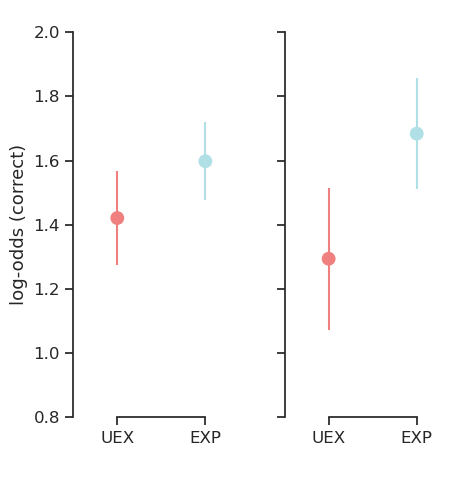

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
dat[0:2].plot(x="irrelevant_expected", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["lightcoral", "powderblue"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(dat[0:2].shape[0]),
            marker='o', s=80, 
            y=dat[0:2]['Estimate'],
            color=["lightcoral", "powderblue"])


dat[2:4].plot(x="irrelevant_expected", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["lightcoral", "powderblue"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(dat[2:4].shape[0]),
            marker='o', s=80, 
            y=dat[2:4]['Estimate'],
            color=["lightcoral", "powderblue"])

ax[0].set_ylabel("log-odds (correct)", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title(" ", fontsize=13)
ax[1].set_title(" ", fontsize=13)
ax[1].set_xlabel(" ")
ax[0].set(ylim=[.8, 2])
ax[1].set(ylim=[.8, 2])
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)
#plt.savefig("figures/exp1/ign_recall.png", dpi=500, bbox_inches='tight')